In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

from openfe_benchmarks import hif2a
from kartograf import KartografAtomMapper
from konnektor.visualization import draw_ligand_network
from openfe.setup.atom_mapping.lomap_scorers import default_lomap_score

system=hif2a.get_system()
compounds = system.ligand_components
#Chem.Draw.MolsToGridImage ([c.to_rdkit() for c in compounds], )

LICENSE: Could not open license file "oe_license.txt" in local directory
LICENSE: N.B. OE_LICENSE environment variable is not set
LICENSE: N.B. OE_DIR environment variable is not set
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!


## Mol Diversity Clustering

In [2]:
from konnektor.utils import CompoundDiversityClustering

from sklearn.cluster import KMeans
from scikit_mol.fingerprints import RDKitFingerprintTransformer, MorganFingerprintTransformer
from scikit_mol.descriptors import MolecularDescriptorTransformer

feat =  RDKitFingerprintTransformer()
cluster = KMeans(n_clusters=3)

In [3]:
cc = CompoundDiversityClustering(featurize= feat,
                            cluster= cluster)

In [4]:
clusters = cc.cluster_compounds(compounds)


/home/bries/programs/miniconda3/envs/openfe/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [5]:
for clusterIDs in range(cluster.n_clusters):
    cs = len([c.to_rdkit() for c in clusters[clusterIDs]])
    print(clusterIDs, cs)

clusterIDs =0
cs = [c.to_rdkit() for c in clusters[clusterIDs]];
[Chem.rdDepictor.Compute2DCoords(c) for c in cs];
#Chem.Draw.MolsToGridImage ([c for c in cs])

0 10
1 9
2 18


## Build Sub-Networks

In [6]:
from openfe import LigandNetwork

from konnektor.network_planners import MinimalSpanningTreeLigandNetworkPlanner, CyclicLigandNetworkPlanner
planner = CyclicLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score)
alt_planner = MinimalSpanningTreeLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score)
sub_networks = []
for cID, mols in clusters.items():
    if(len(mols)>1):
        if(len(mols)>2):
            sub_network = planner(mols)
            sub_networks.append(sub_network)
        else:
            sub_network = alt_planner(mols)
            sub_networks.append(sub_network)
    else:
        continue
        sub_network = LigandNetwork(edges=set([]), nodes=mols)
        sub_networks.append(sub_network)

/home/bries/programs/miniconda3/envs/openfe/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
/tmp/ipykernel_28062/842243941.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


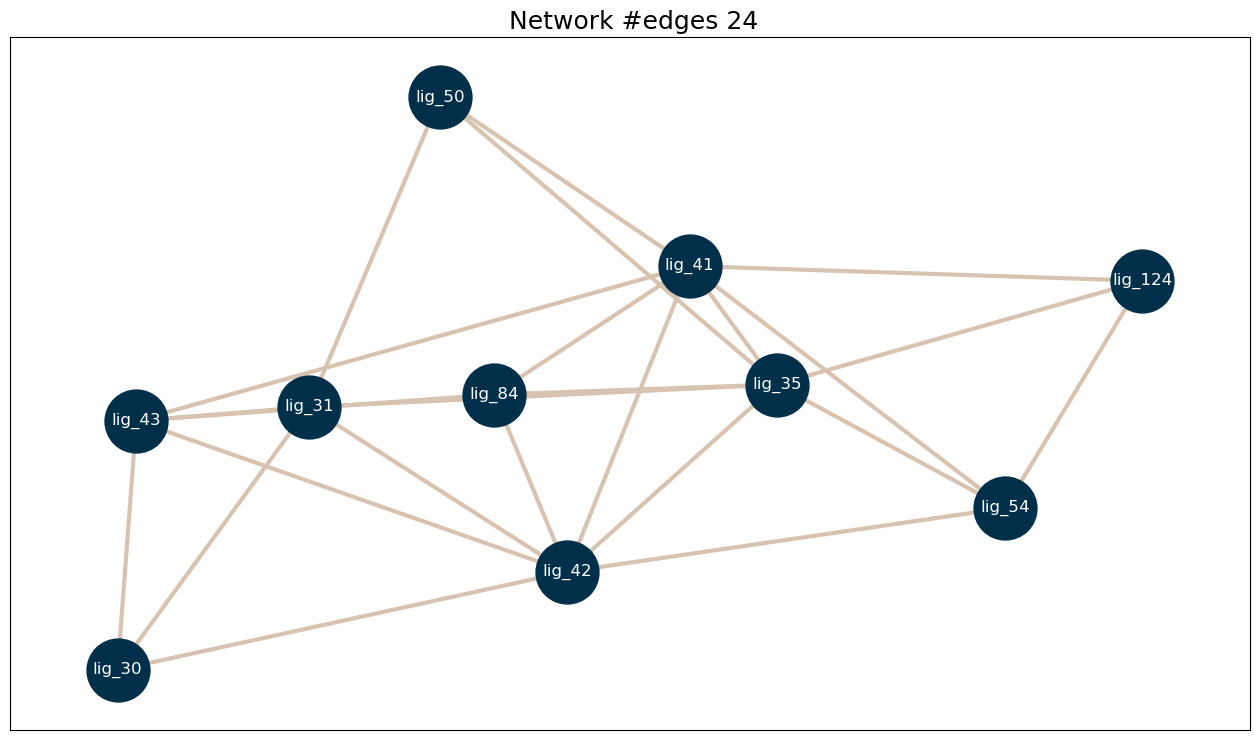

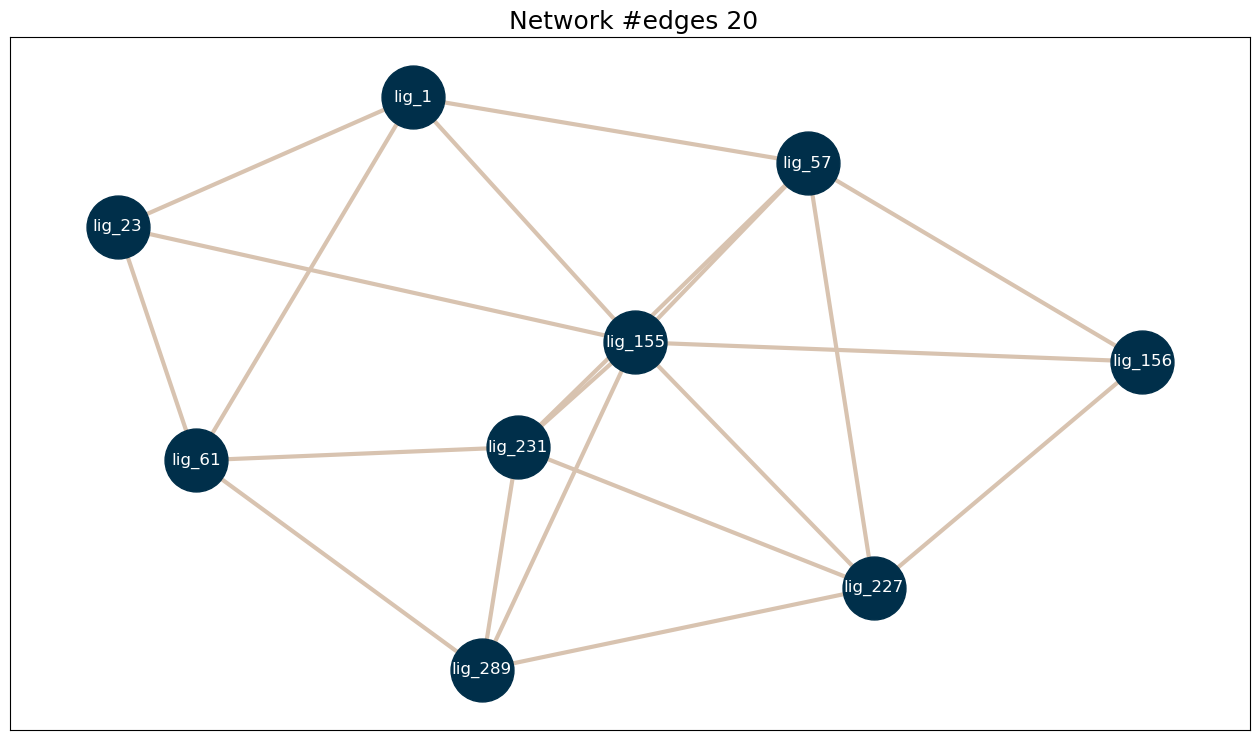

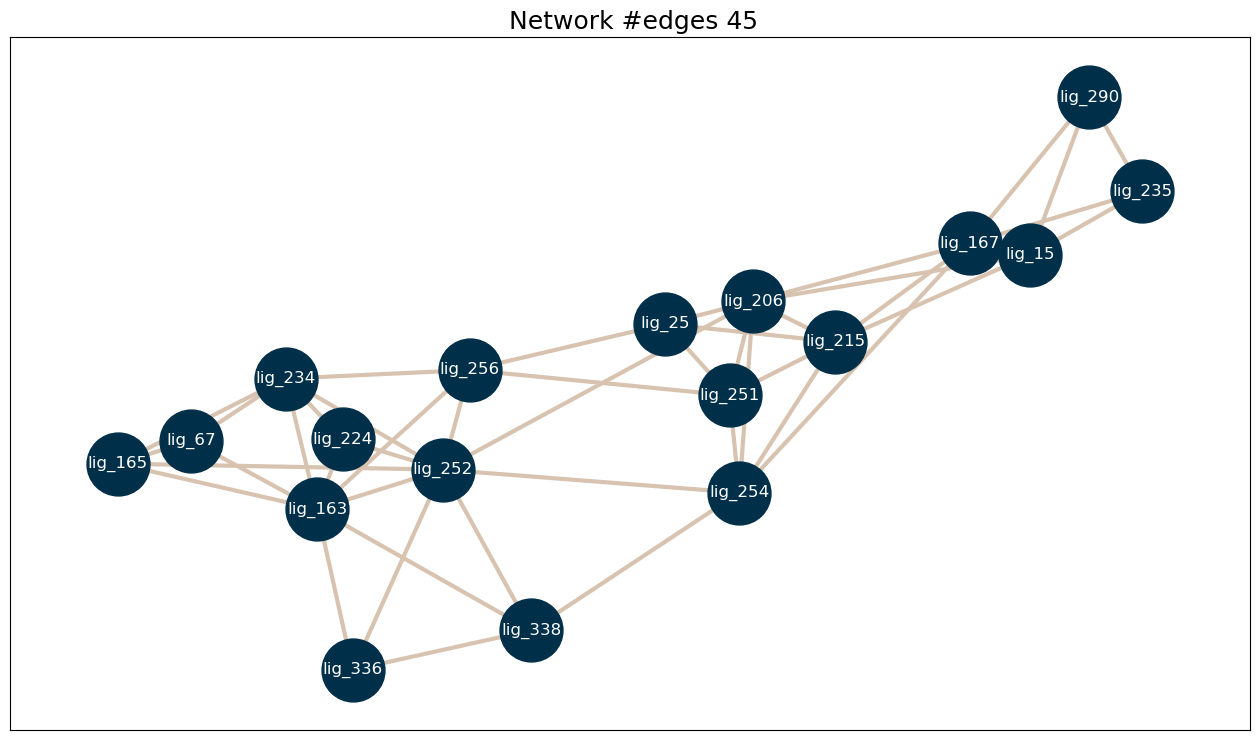

In [7]:
#Visualize sub-networks
for sub in sub_networks:
    fig = draw_ligand_network(sub);
    fig.show()

## Concat Sub-Networks
Consider here Edge Coloring for destinguishing concatenation edges, next you could decide to add any type of transformation for those.


In [8]:
#Concat Networks
concat_network = planner.concatenate_networks(ligandNetworks=sub_networks, nEdges=3)

INFO:	Number of edges in individual networks:
89/[24, 20, 45]
INFO:	Adding ConnectingEdges: 3
INFO:	Adding ConnectingEdges: 4
INFO:	Adding ConnectingEdges: 5
INFO:	Total Concatenating Edges: 5
INFO:	Total Concatenated Edges: 94


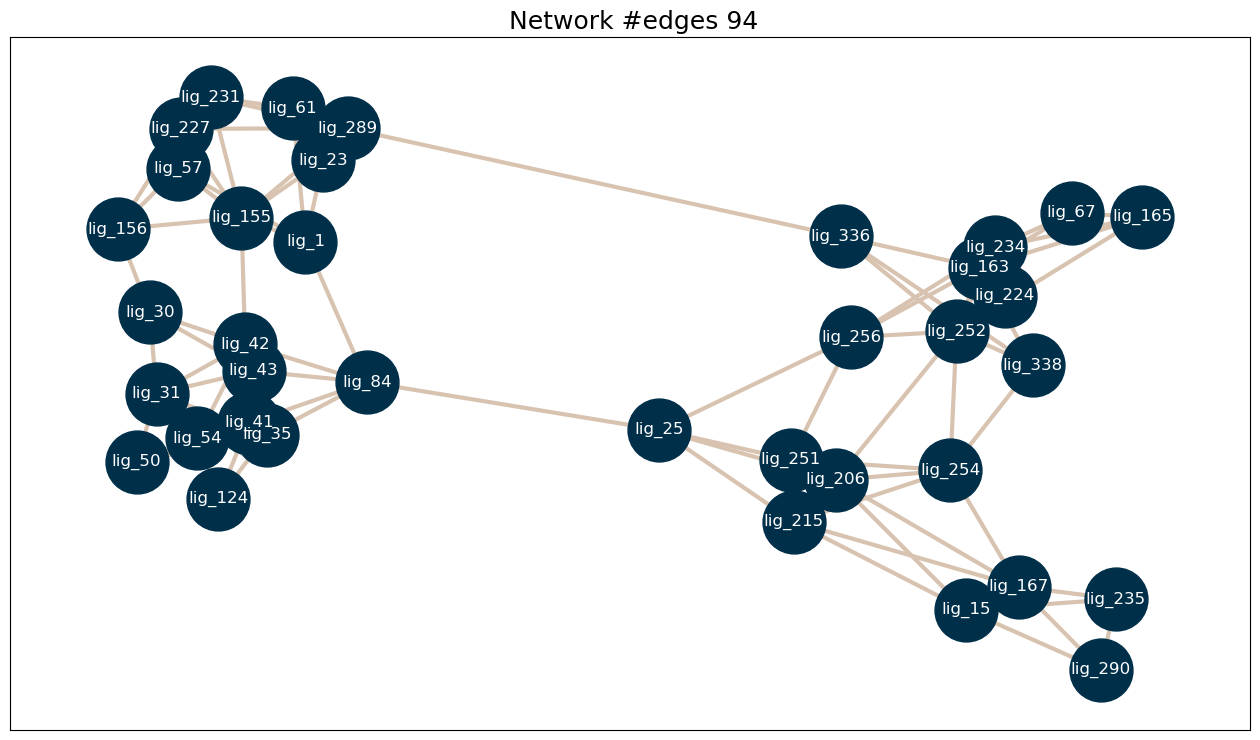

In [9]:
draw_ligand_network(concat_network);

# Concluding Overview Figure

/tmp/ipykernel_28062/2947856527.py:26: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


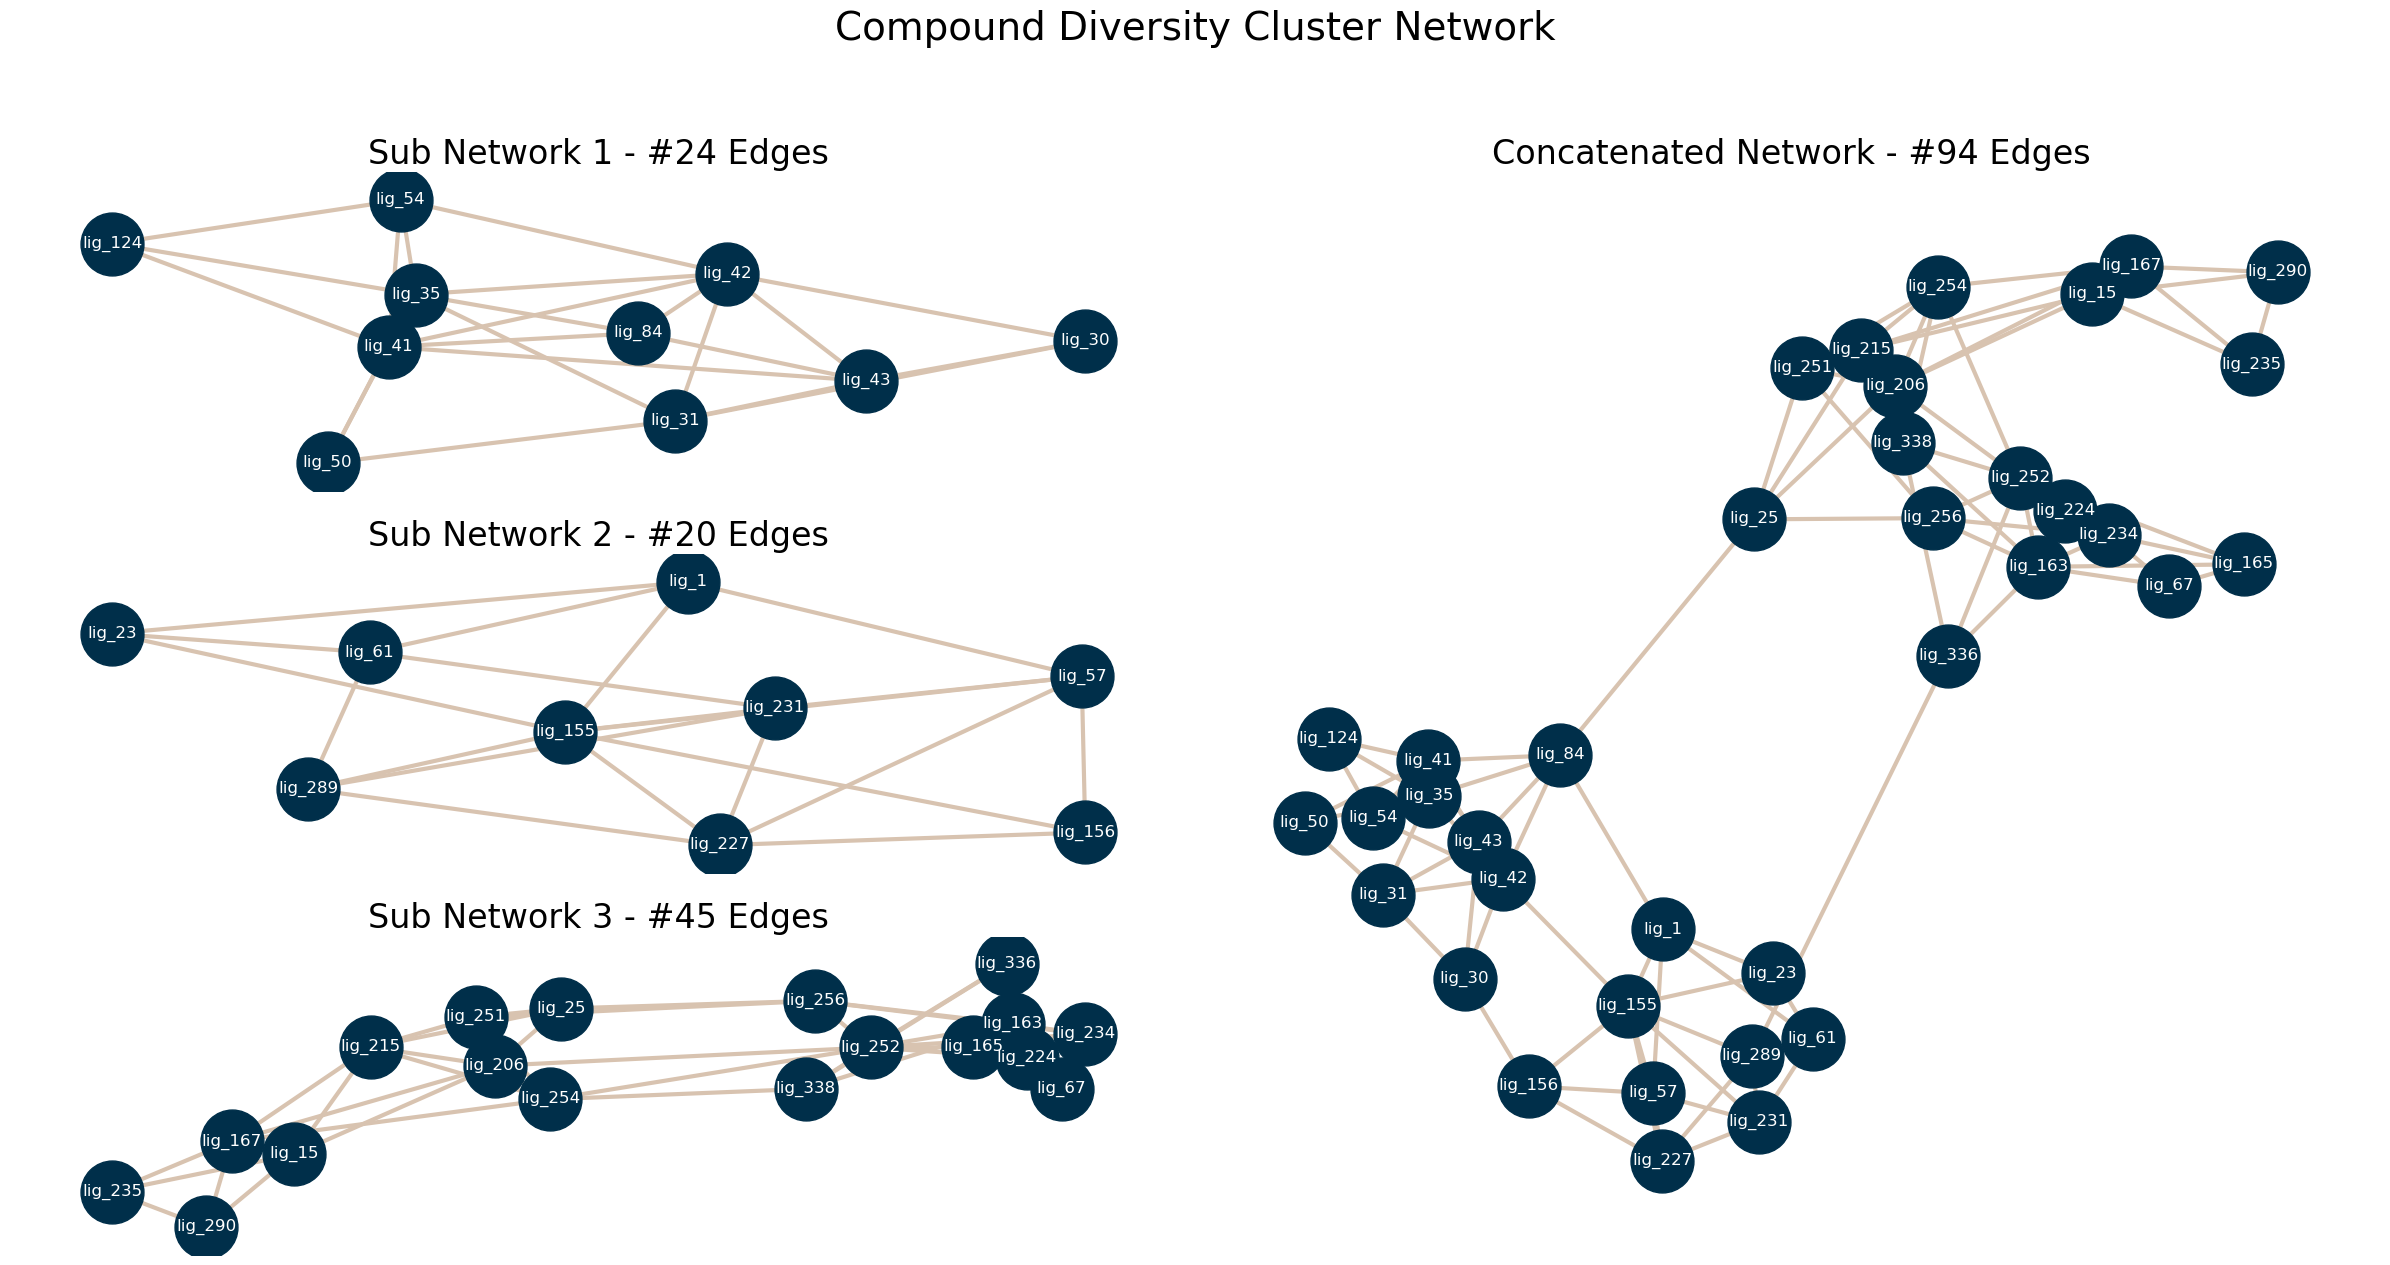

In [17]:
from matplotlib import pyplot as plt
fig = plt.figure(layout="constrained", figsize=[12*2,12])

gs0 = fig.add_gridspec(1, 2)
gs1 = gs0[0].subgridspec(3, 1)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])
ax3 = fig.add_subplot(gs1[2])

axes = [ax1, ax2, ax3]
#Visualize sub-networks
i=1
for ax, sub in zip(axes, sub_networks):
    draw_ligand_network(sub, ax=ax);
    ax.set_title("Sub Network "+str(i)+" - #"+str(len(sub.edges))+" Edges", fontsize=24)
    ax.axis("off")
    i+=1


gs2 = gs0[1].subgridspec(1, 1)
ax3 = fig.add_subplot(gs2[0])
draw_ligand_network(concat_network, ax=ax3);
ax3.set_title("Concatenated Network - #94 Edges", fontsize=24)
ax3.axis("off")
fig.suptitle("Compound Diversity Cluster Network",fontsize=28, y=1.05)
fig.tight_layout()

In [18]:
fig.savefig("../.img/Divesity_network.png")